Recommendation System
1.content-based model
2.collaborative filtering model
3.hybrid

1. Content-based model
- Ma trận user-item được xây dựng dựa theo "nội dung" của item mà không quan tâm mối liên hệ giữa các user
- item được phân loại theo từng cluster theo từng mục đích (nội dung, tags, ...)
- Xây dựng ma trận theo độ tương quan 
1.1 Utility matrix
- Là ma trận với index hàng là user và cột là item (NxM)
- Giá trị được sử dụng là điểm rating của từng user với một hay nhiều item. Điều này dẫn đến ma trận xây dựng được là ma trận thưa

In [40]:
import os
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD, NMF
from surprise.model_selection import cross_validate

import utils

sns.set(rc={'figure.figsize':(10, 6)})

## 1. Load data

### Summary

```
ml-1m
├── users.dat
├── movies.dat
├── ratings.dat
└── README.txt
```

In [2]:
PATH = "/home/vietnd/Documents/movielens-1m/ml-1m"
ratings = pd.read_csv(os.path.join(PATH, 'ratings.dat'), sep='::', names=["userID", "movieID", "rating", "timestamp"], engine='python')
movies = pd.read_csv(os.path.join(PATH, 'movies.dat'), sep='::', names=["movieID", "title", "genres"], engine='python')
users = pd.read_csv(os.path.join(PATH, 'users.dat'), sep='::', names=["userID", "gender", "age", "occupation", "zipcode"], engine='python')

In [3]:
users

,userID,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


## 2. EDA

### 2.1 ratings.dat

In [4]:
ratings.head()

,userID,movieID,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


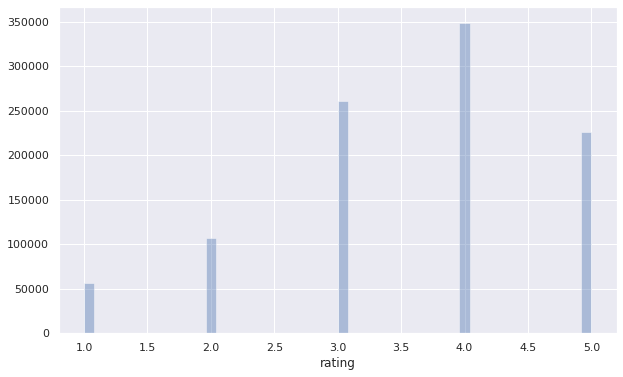

In [5]:
sns.distplot(ratings["rating"], kde=False)

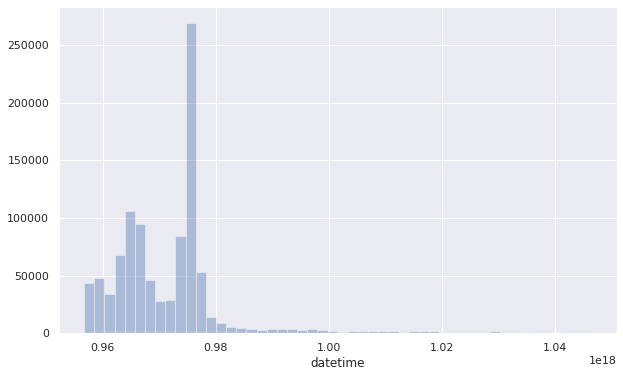

In [30]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.drop('timestamp', axis=1, inplace=True)
sns.distplot(ratings['datetime'], kde=False)

In [7]:
num_userId = len(ratings.userID.unique())
num_movieId = len(ratings.movieID.unique())
print(num_userId)
print(num_movieId)
print("Coverage : {:.4f}%".format(len(ratings) * 100 / (num_userId * num_movieId)))

6040
3706
Coverage : 4.4684%


### 2.2 movies.dat

In [8]:
movies.head()

,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies_refine = movies.copy()
movies_refine['year'] = (movies_refine['title'].str.extract(r'(\d{4})')).astype('int32')
movies_refine = movies_refine.dropna()
movies_refine['title'] = (movies_refine['title'].str.extract(r'(^[^\(]+)'))[0]
movies_refine['genres'] = movies_refine['genres'].str.split('|')

movies_refine

,movieID,title,genres,year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


In [10]:
movies_refine.year.unique()
movies_refine.year.value_counts()

1996    344
1995    342
1998    335
1997    314
1999    281
       ... 
2001      1
2010      1
3000      1
1921      1
8230      1
Name: year, Length: 88, dtype: int64

In [11]:
genre_count = dict()
for index, series in movies_refine.iterrows():
    for genre in series['genres']:
        genre_count[genre] = genre_count.get(genre, 0) + 1
pprint(genre_count)

{'Action': 503,
 'Adventure': 283,
 'Animation': 105,
 "Children's": 251,
 'Comedy': 1200,
 'Crime': 211,
 'Documentary': 127,
 'Drama': 1603,
 'Fantasy': 68,
 'Film-Noir': 44,
 'Horror': 343,
 'Musical': 114,
 'Mystery': 106,
 'Romance': 471,
 'Sci-Fi': 276,
 'Thriller': 492,
 'War': 143,
 'Western': 68}


### 2.3 users.dat

In [12]:
users.head()

,userID,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
users.gender.value_counts()

M    4331
F    1709
Name: gender, dtype: int64

In [14]:
users.age.value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [15]:
len(users)

6040

In [16]:
len(ratings.userID.unique())

6040

## 3. Matrix Factorization Collaborative Filtering

Giải quyết vấn đề về ma trận thưa
- Tính mean của giá trị theo hàng :
$E(x) = \sum_{i=1}^{m} v_i $
- Chuẩn hoá : trừ giá trị hàng cho mean của từng hàng

- Tính ma trận hiệp phương sai :
(công thức)

SVD:
Tách utility matrix thành 3 ma trận : user - strength, strength - strength, strength - item
Ví dụ:
$$\begin{bmatrix}
 3 &2 &2 \\
  2  &3 &-2 
\end{bmatrix}
=
\begin{bmatrix}
 1/\sqrt[]{2}  & 1/\sqrt[]{2} \\
  1/\sqrt[]{2}  & -1/\sqrt[]{2} 
\end{bmatrix}
.
\begin{bmatrix}
 5 &0 &0 \\
 0 &3 &0 
\end{bmatrix}
.
\begin{bmatrix}
 1/\sqrt[]{2}  & 1/\sqrt[]{2}  &0 \\
  1/\sqrt[]{18}  & -1/\sqrt[]{18} & -1/\sqrt[]{18} \\
2/3 & -2/3 & -1/3
\end{bmatrix} $$

Giả sử ma trận A(2x3) tương ứng với 2 user - 3 items , value là rating của mỗi user tương ứng với mỗi item:
- Ma trận U (2x2) : mỗi cột thể hiện độ "mạnh" tương ứng trị riêng của ma trận $\sum$
- Ma trận $\sum$ (2x3): là ma trận đường chéo với trị riêng giảm dần (Giá trị $\sigma _{1}$ là giá trị có độ mạnh )
- Ma trận V (3x3) : mỗi hàng thể hiện khả năng match giữ mỗi cluster của item và điểm rating của mỗi user

### 3.1 Truncated SVD in Linear Algebra

In [18]:
data_mat = np.array(ratings.pivot(index = 'movieID', columns = 'userID', values = 'rating'))
data_mat = np.nan_to_num(data_mat)

In [19]:
data_mat

array([[5., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
train, test = utils.train_test_split(data_mat, train_ratio=0.8, base='user')

In [21]:
train.shape

(3706, 4832)

In [22]:
nor_data_mat = train - np.mean(train, axis = 0)
u, s, vT = svds(nor_data_mat, k = 50)  # 50 eigenvalues

In [23]:
recon_data_mat = u.dot(np.diag(s)).dot(vT)
recon_data_mat

array([[-0.0787016 , -0.04247994, -0.00753672, ..., -0.15773316,
        -0.15406719, -0.08304151],
       [ 0.09091207,  0.10026825, -0.13003095, ...,  0.62251132,
        -0.14755587, -0.18711723],
       [-0.04228537, -0.10348336, -0.0370179 , ..., -0.15874653,
        -0.24539651, -0.11655114],
       ...,
       [-0.00661594, -0.1615517 , -0.03086404, ..., -0.1611386 ,
        -0.23941493, -0.00785262],
       [-0.14884603,  0.86308432, -0.3164217 , ...,  0.5543637 ,
         0.81519941, -0.07725894],
       [-0.05468844, -0.1279859 , -0.03584084, ..., -0.10641736,
        -0.31205852, -0.08703523]])

In [24]:
recon_data_mat.shape

(3706, 4832)

In [218]:
def recommend_movies(pred_matrix, userID, num_recommendations):
    """Recommend movies based on reconstructed svd matrix
    Params:
     - pred_matrix (num_movies, num_users) : reconstructed matrix
     - userID (scalar)
     - num_recommendations (scalar)
    Outputs:
     - movies
    """
    sorted_predict_idx = np.argsort(pred_matrix[:, userID-1])[::-1]

    user_data = ratings[ratings.userID == (userID)]
    user_full = user_data.merge(movies_refine).sort_values(['rating'], ascending=False)
    # print(user_full)
    print('User {0} has already rated {1} movies.'.format(userID, len(user_full)))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))

    recommendations = movies_refine.iloc[sorted_predict_idx, :][~movies_refine.movieID.isin(user_full.movieID)]

    return user_full, recommendations.head(num_recommendations)

In [ ]:
rated, _ = recommend_movies(recon_data_mat, 1310, 20)
_

#### SVD in Recommendation System

### 3.2 Nonnegative Matrix Factorization

### 3.3 Deep learning